# DeepLabCut Test Notebook for Data Visualization

The objective of this notebook is to figure out how to read, handle, and visualize DLC data so that we can "quantify" the behavior of mice and compare WT to disease models.

In [2]:
# handling data
import pandas as pd
import numpy as np
import openpyxl

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.imputation.mice import MICEData
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value Stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#Extras
from utils import *
import math

#Time data stuff, neural network stuff?
import time
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime


#Data processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#ML models
import xgboost as xgb
import catboost as ctb


print("Setup Complete")

Setup Complete


In [3]:
pwd


'/Users/aidanlew/DLC'

In [4]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


# Setting Up the Data

In [5]:
snout_trim_csv_df=pd.read_csv('../Documents/cage1_trim_1.3.csv',
                             #skiprows=1
                             )
snout_trim_csv_df.head()

,Home_Mouse_Snout_x,Home_Mouse_Snout_y,Unfamiliar_Mouse_Snout_x,Unfamiliar_Mouse_Snout_y,Familiar_Mouse_Snout_x,Familiar_Mouse_Snout_y,Home_Avg,Unfamiliar_Avg,Familiar_Avg
0,131.717,652.864,NaN,NaN,NaN,NaN,392.295,NaN,NaN
1,132.986,652.864,NaN,NaN,NaN,NaN,392.925,NaN,NaN
2,139.844,666.580,NaN,NaN,NaN,NaN,43.212,NaN,NaN
3,1314.920,652.864,NaN,NaN,NaN,NaN,983.892,NaN,NaN
4,1362.317,652.864,NaN,NaN,NaN,NaN,17.595,NaN,NaN


In [6]:
snout_trimAvg_csv_df=pd.read_csv('../Documents/cage1_trim_1.3.csv',
                             #skiprows=1,
                               usecols= ['Home_Avg','Unfamiliar_Avg','Familiar_Avg']
                             )
snout_trimAvg_csv_df.head()

,Home_Avg,Unfamiliar_Avg,Familiar_Avg
0,392.295,NaN,NaN
1,392.925,NaN,NaN
2,43.212,NaN,NaN
3,983.892,NaN,NaN
4,17.595,NaN,NaN


In [7]:
trim_full_df=pd.read_csv('../Documents/cage1_full_csv.csv',
                             #skiprows=1
                             )
trim_full_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,131.717,652.864,1239.165,611.649,1219.919,663.535,148.613,555.498,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132.986,652.864,124.815,611.649,1225.550,663.535,161.714,555.498,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,139.844,666.580,1242.685,611.649,1229.363,666.626,167.971,555.498,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1314.920,652.864,1254.826,62.351,1244.599,663.535,178.319,553.846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1362.317,652.864,1266.893,599.760,1264.740,663.535,178.384,553.846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Imputation Strategies
    - Sipmple Imputation: Basically takes the means and imputes them - doesn't factor in the other imputed values
    - Iterative Imputation: Inspried by MICE, looks to return values based on all the other ones
    - MICE: Uses the chain formula method to impute values which takes into accounnt thee other imputed values

In [8]:
#Using Simple Imputation to impute the missing values 
    #Note: Need NaN values – i.e. from CSV not Excel
snout_trim_csv_df.astype('float')
snout_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
snout_Simp.fit(snout_trim_csv_df)
snout_simpleimp_ar = snout_Simp.transform(snout_trim_csv_df)
snout_simpleimp_ar[5]


array([ 138.433     ,  659.166     , 1143.30285484,  646.65953226,
       1294.53521739,  498.28017391,  398.7995    ,  237.60420968,
        256.35684783])

In [9]:
### NOTE The imputer functions can't have whitespace in the column names ####

#Make copies so that the origional df is not altered (causing issues with the other functions that use it)
snout_trimAvg_csv_df.astype('float')
snout_simple_df = snout_trimAvg_csv_df.copy()
snout_iter_df = snout_trimAvg_csv_df.copy()

#Simple Imputation for the average snout position
snout_avg_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
snout_avg_Simp.fit(snout_simple_df)
snout_avg_simpleimp_ar = snout_avg_Simp.transform(snout_simple_df)
snout_avg_simpleimp_df = pd.DataFrame(snout_avg_simpleimp_ar, columns = ['Home_Avg','Unfamiliar_Avg','Familiar_Avg'])

#Iterative Imputation for the average snout position
snout_avg_Iimp= IterativeImputer(random_state=0)
snout_avg_Iimp.fit(snout_iter_df)
snout_avg_iterimp_ar = snout_avg_Iimp.transform(snout_iter_df)
snout_iterimp_df = pd.DataFrame(snout_avg_iterimp_ar, columns = ['Home_Avg','Unfamiliar_Avg','Familiar_Avg'])

#snout_trimAvg_csv_df.Head()
#snout_simple_df.Head()
#snout_iter_df.Head()


[IterativeImputer] Early stopping criterion not reached.


Text(0.5, 1.0, 'Iterative Imputed Average')

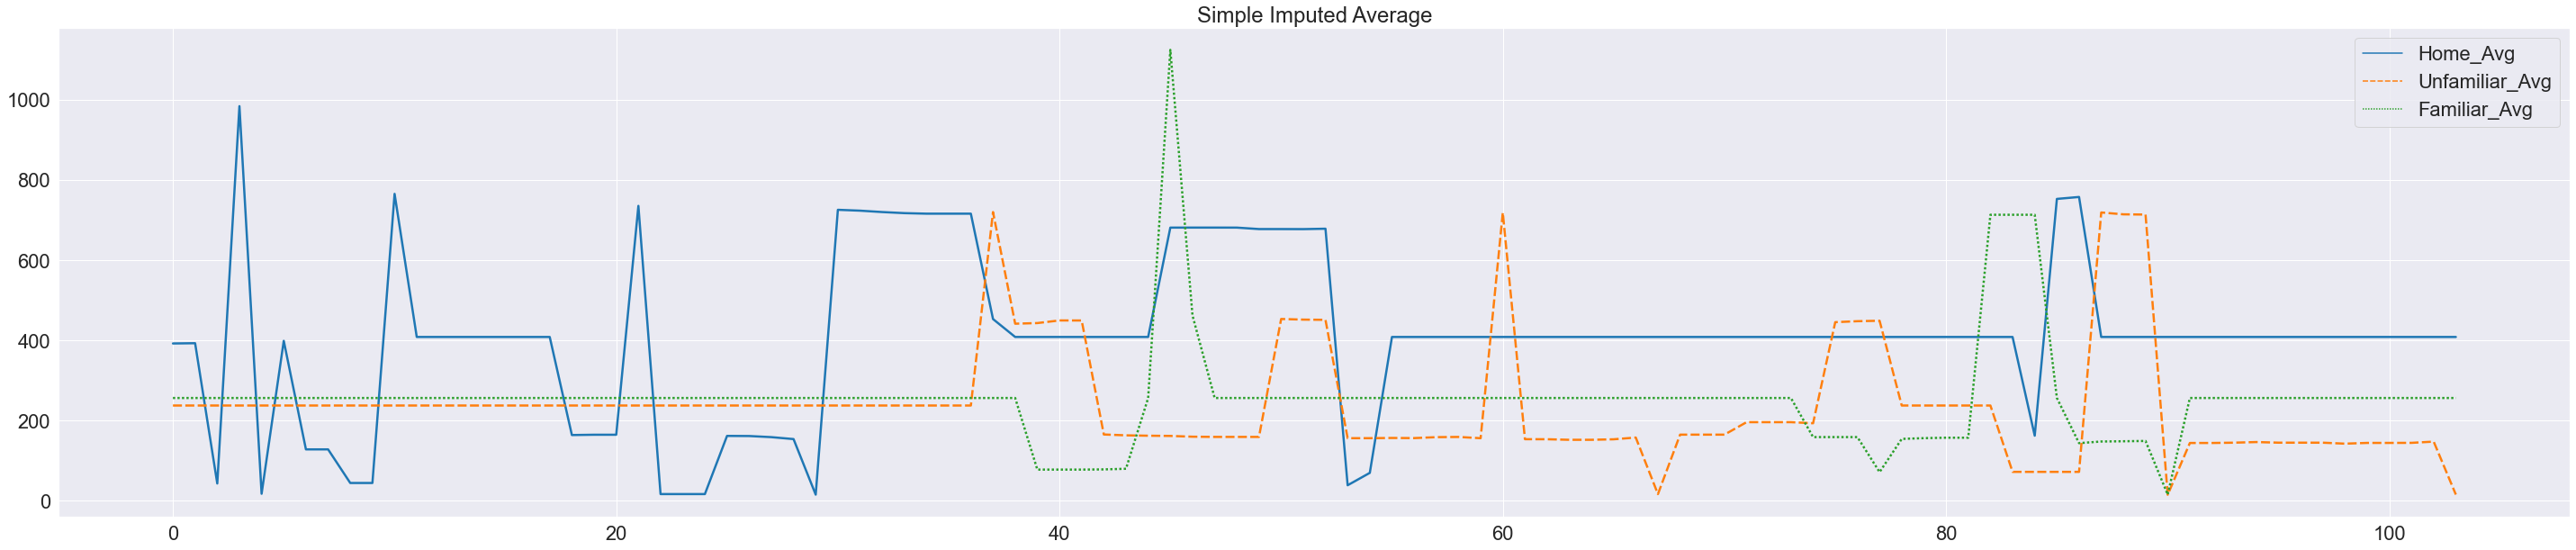

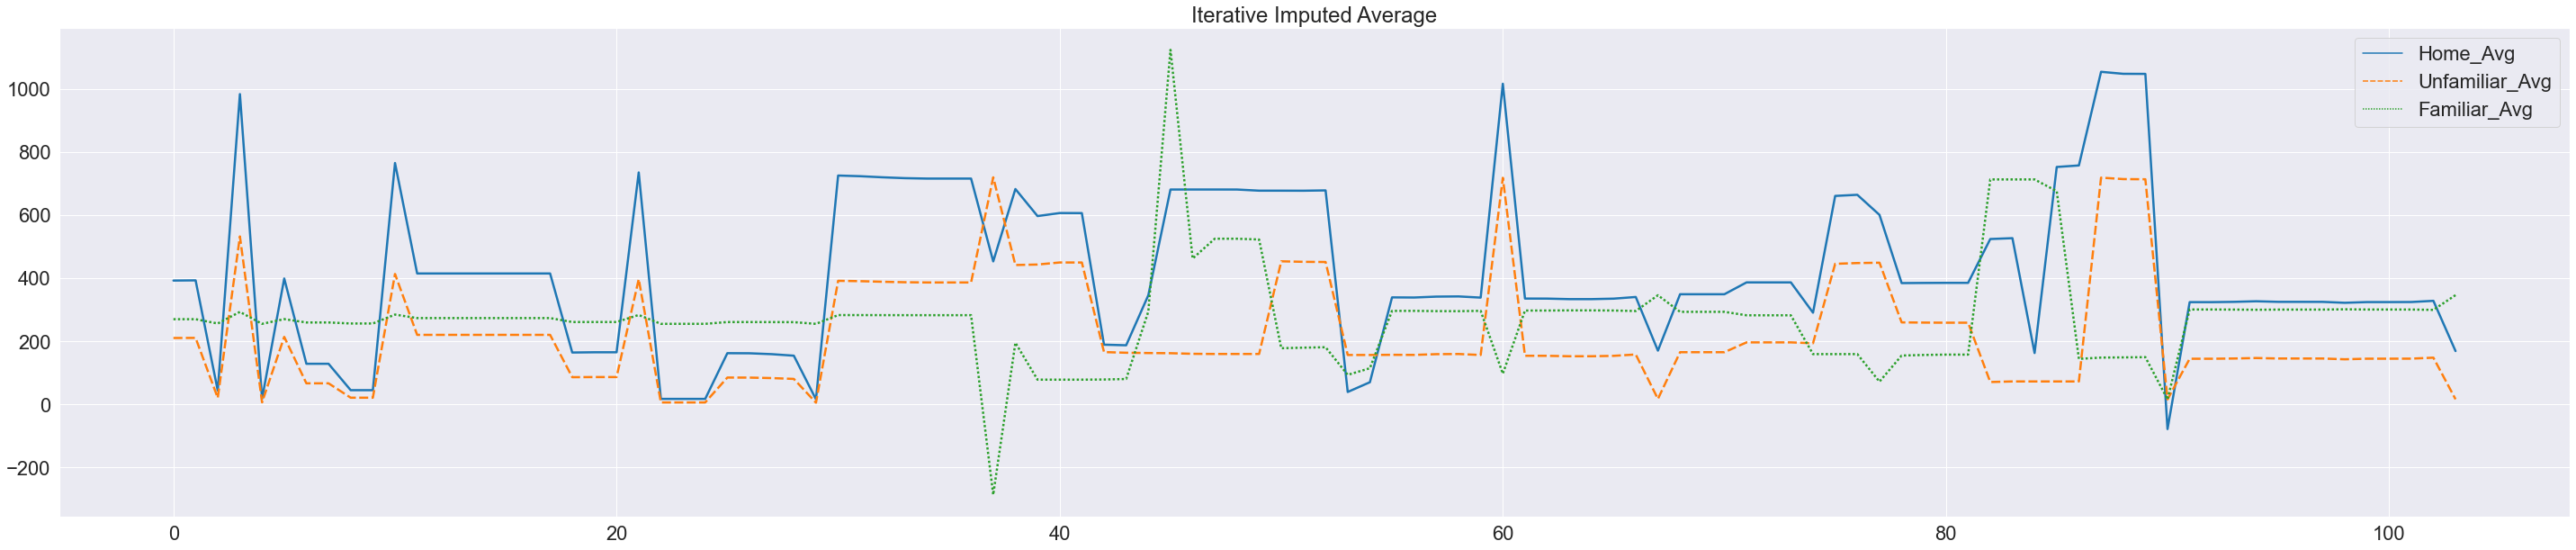

In [10]:
#Plotting Simple Imputation average snout data w/ for loop
ax = sns.set(font_scale=2)
plt.figure(figsize=(50,10))
sns.lineplot(data=snout_avg_simpleimp_df, palette="tab10", linewidth=2.5, legend =['Home_Avg','Unfamiliar_Avg','Familiar_Avg'])
plt.title('Simple Imputed Average')

#Plotting Iterative Imputatiion average snout data
plt.figure(figsize=(50,10))
sns.lineplot(data=snout_iterimp_df, palette="tab10", linewidth=2.5)
plt.title('Iterative Imputed Average')


## Imputation Conclusion:
It looks like Simple Imputation is the best option becuase one mouse's predicted position doesn't affect other preddicted positions (e.g. notice where two mice spike in the Iter. graph compared to the simple graph), which would lead to analysis showing that they are more dependent then they acctually are. Also (not shown) when Itterative Imputation was run for each mouse individually, the results were congruent with Simple Imputation. Additionally, assuming that the law of means applies here, we can infer that the mean positions imputated will be more relective of the acctual mean (and therefore mean distances, etc.) of the acctual mice.
 - Note for Aidan: SimpleImputation uses per-column mthodology alreaddy (as confirmed by data not shown)

# Impute and Manipulate all Data

In [11]:
added_trim_df = trim_full_df.copy()

#Simple Imputation for the average snout position
added_trim_Simp= SimpleImputer(missing_values=np.nan, strategy='mean')
added_trim_Simp.fit(added_trim_df)
added_trim_simpleimp_ar = added_trim_Simp.transform(added_trim_df)
added_trim_simpleimp_df = pd.DataFrame(added_trim_simpleimp_ar, 
        columns = ['HomeMouse_Snout_x', 'HomeMouse_Snout_y', 'HomeMouse_LeftEar_x',
       'HomeMouse_LeftEar_y', 'HomeMouse_RightEar_x', 'HomeMouse_RightEar_y',
       'HomeMouse_Tailbase_x', 'HomeMouse_Tailbase_y',
       'UnfamiliarMouse_Snout_x', 'UnfamiliarMouse_Snout_y',
       'UnfamiliarMouse_LeftEar_x', 'UnfamiliarMouse_LeftEar_y',
       'UnfamiliarMouse_RightEar_x', 'UnfamiliarMouse_RightEar_y',
       'UnfamiliarMouse_Tailbase_x', 'UnfamiliarMouse_Tailbase_y',
       'FamiliarMouse_Snout_x', 'FamiliarMouse_Snout_y',
       'FamiliarMouse_LeftEar_x', 'FamiliarMouse_LeftEar_y',
       'FamiliarMouse_RightEar_x', 'FamiliarMouse_RightEar_y',
       'FamiliarMouse_Tailbase_x', 'FamiliarMouse_Tailbase_y'])

added_trim_simpleimp_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,UnfamiliarMouse_Tailbase_x,UnfamiliarMouse_Tailbase_y,FamiliarMouse_Snout_x,FamiliarMouse_Snout_y,FamiliarMouse_LeftEar_x,FamiliarMouse_LeftEar_y,FamiliarMouse_RightEar_x,FamiliarMouse_RightEar_y,FamiliarMouse_Tailbase_x,FamiliarMouse_Tailbase_y
0,131.717,652.864,1239.165,611.649,1219.919,663.535,148.613,555.498,1143.302855,646.659532,...,1084.006314,462.403714,1294.535217,498.280174,736.24787,579.160913,1188.57487,461.487043,919.332565,499.36687
1,132.986,652.864,124.815,611.649,1225.550,663.535,161.714,555.498,1143.302855,646.659532,...,1084.006314,462.403714,1294.535217,498.280174,736.24787,579.160913,1188.57487,461.487043,919.332565,499.36687
2,139.844,666.580,1242.685,611.649,1229.363,666.626,167.971,555.498,1143.302855,646.659532,...,1084.006314,462.403714,1294.535217,498.280174,736.24787,579.160913,1188.57487,461.487043,919.332565,499.36687
3,1314.920,652.864,1254.826,62.351,1244.599,663.535,178.319,553.846,1143.302855,646.659532,...,1084.006314,462.403714,1294.535217,498.280174,736.24787,579.160913,1188.57487,461.487043,919.332565,499.36687
4,1362.317,652.864,1266.893,599.760,1264.740,663.535,178.384,553.846,1143.302855,646.659532,...,1084.006314,462.403714,1294.535217,498.280174,736.24787,579.160913,1188.57487,461.487043,919.332565,499.36687


In [12]:
# 1.)Get distance between the diff x&y coords
# 2.)Average the distances for each marker
# 3.)Average all the markers between the mice

#Home Mouse and Unfamiliar Mouse
#See the distances between the coordinate points for each markerbeetween mice
added_trim_simpleimp_df['H&U_Sx']= (added_trim_simpleimp_df['HomeMouse_Snout_x']-added_trim_simpleimp_df['UnfamiliarMouse_Snout_x']).abs()
added_trim_simpleimp_df['H&U_Sy']= (added_trim_simpleimp_df['HomeMouse_Snout_y']-added_trim_simpleimp_df['UnfamiliarMouse_Snout_y']).abs()
added_trim_simpleimp_df['H&U_LEx']= (added_trim_simpleimp_df['HomeMouse_LeftEar_x']-added_trim_simpleimp_df['UnfamiliarMouse_LeftEar_x']).abs()
added_trim_simpleimp_df['H&U_LEy']= (added_trim_simpleimp_df['HomeMouse_LeftEar_y']-added_trim_simpleimp_df['UnfamiliarMouse_LeftEar_y']).abs()
added_trim_simpleimp_df['H&U_REx']= (added_trim_simpleimp_df['HomeMouse_RightEar_x']-added_trim_simpleimp_df['UnfamiliarMouse_RightEar_x']).abs()
added_trim_simpleimp_df['H&U_REy']= (added_trim_simpleimp_df['HomeMouse_RightEar_y']-added_trim_simpleimp_df['UnfamiliarMouse_RightEar_y']).abs()
added_trim_simpleimp_df['H&U_TBx']= (added_trim_simpleimp_df['HomeMouse_Tailbase_x']-added_trim_simpleimp_df['UnfamiliarMouse_Tailbase_x']).abs()
added_trim_simpleimp_df['H&U_TBy']= (added_trim_simpleimp_df['HomeMouse_Tailbase_y']-added_trim_simpleimp_df['UnfamiliarMouse_Tailbase_y']).abs()

#Average distnce of each marker between mice
added_trim_simpleimp_df['H&U_S_mean'] = added_trim_simpleimp_df[['H&U_Sx','H&U_Sy']].mean(axis=1)
added_trim_simpleimp_df['H&U_LE_mean'] = added_trim_simpleimp_df[['H&U_LEx','H&U_LEy']].mean(axis=1)
added_trim_simpleimp_df['H&U_RE_mean'] = added_trim_simpleimp_df[['H&U_REx','H&U_REy']].mean(axis=1)
added_trim_simpleimp_df['H&U_TB_mean'] = added_trim_simpleimp_df[['H&U_TBx','H&U_TBy']].mean(axis=1)

#Average distance of mice from each other
added_trim_simpleimp_df['Average_H&U'] = added_trim_simpleimp_df[['H&U_S_mean','H&U_LE_mean','H&U_RE_mean','H&U_TB_mean']].mean(axis=1)


#added_trim_simpleimp_df.head()


In [13]:
#Home Mouse and Familiar Mouse
#See the distances between the coordinate points for each markerbeetween mice
added_trim_simpleimp_df['H&F_Sx']= (added_trim_simpleimp_df['HomeMouse_Snout_x']-added_trim_simpleimp_df['FamiliarMouse_Snout_x']).abs()
added_trim_simpleimp_df['H&F_Sy']= (added_trim_simpleimp_df['HomeMouse_Snout_y']-added_trim_simpleimp_df['FamiliarMouse_Snout_y']).abs()
added_trim_simpleimp_df['H&F_LEx']= (added_trim_simpleimp_df['HomeMouse_LeftEar_x']-added_trim_simpleimp_df['FamiliarMouse_LeftEar_x']).abs()
added_trim_simpleimp_df['H&F_LEy']= (added_trim_simpleimp_df['HomeMouse_LeftEar_y']-added_trim_simpleimp_df['FamiliarMouse_LeftEar_y']).abs()
added_trim_simpleimp_df['H&F_REx']= (added_trim_simpleimp_df['HomeMouse_RightEar_x']-added_trim_simpleimp_df['FamiliarMouse_RightEar_x']).abs()
added_trim_simpleimp_df['H&F_REy']= (added_trim_simpleimp_df['HomeMouse_RightEar_y']-added_trim_simpleimp_df['FamiliarMouse_RightEar_y']).abs()
added_trim_simpleimp_df['H&F_TBx']= (added_trim_simpleimp_df['HomeMouse_Tailbase_x']-added_trim_simpleimp_df['FamiliarMouse_Tailbase_x']).abs()
added_trim_simpleimp_df['H&F_TBy']= (added_trim_simpleimp_df['HomeMouse_Tailbase_y']-added_trim_simpleimp_df['FamiliarMouse_Tailbase_y']).abs()

#Average distnce of each marker between mice
added_trim_simpleimp_df['H&F_S_mean'] = added_trim_simpleimp_df[['H&F_Sx','H&F_Sy']].mean(axis=1)
added_trim_simpleimp_df['H&F_LE_mean'] = added_trim_simpleimp_df[['H&F_LEx','H&F_LEy']].mean(axis=1)
added_trim_simpleimp_df['H&F_RE_mean'] = added_trim_simpleimp_df[['H&F_REx','H&F_REy']].mean(axis=1)
added_trim_simpleimp_df['H&F_TB_mean'] = added_trim_simpleimp_df[['H&F_TBx','H&F_TBy']].mean(axis=1)

#Average distance of mice from each other
added_trim_simpleimp_df['Average_H&F'] = added_trim_simpleimp_df[['H&F_S_mean','H&F_LE_mean','H&F_RE_mean','H&F_TB_mean']].mean(axis=1)

#added_trim_simpleimp_df.head()

In [14]:
#Home Mouse and Familiar Mouse
#See the distances between the coordinate points for each markerbeetween mice
added_trim_simpleimp_df['U&F_Sx']= (added_trim_simpleimp_df['UnfamiliarMouse_Snout_x']-added_trim_simpleimp_df['FamiliarMouse_Snout_x']).abs()
added_trim_simpleimp_df['U&F_Sy']= (added_trim_simpleimp_df['UnfamiliarMouse_Snout_y']-added_trim_simpleimp_df['FamiliarMouse_Snout_y']).abs()
added_trim_simpleimp_df['U&F_LEx']= (added_trim_simpleimp_df['UnfamiliarMouse_LeftEar_x']-added_trim_simpleimp_df['FamiliarMouse_LeftEar_x']).abs()
added_trim_simpleimp_df['U&F_LEy']= (added_trim_simpleimp_df['UnfamiliarMouse_LeftEar_y']-added_trim_simpleimp_df['FamiliarMouse_LeftEar_y']).abs()
added_trim_simpleimp_df['U&F_REx']= (added_trim_simpleimp_df['UnfamiliarMouse_RightEar_x']-added_trim_simpleimp_df['FamiliarMouse_RightEar_x']).abs()
added_trim_simpleimp_df['U&F_REy']= (added_trim_simpleimp_df['UnfamiliarMouse_RightEar_y']-added_trim_simpleimp_df['FamiliarMouse_RightEar_y']).abs()
added_trim_simpleimp_df['U&F_TBx']= (added_trim_simpleimp_df['UnfamiliarMouse_Tailbase_x']-added_trim_simpleimp_df['FamiliarMouse_Tailbase_x']).abs()
added_trim_simpleimp_df['U&F_TBy']= (added_trim_simpleimp_df['UnfamiliarMouse_Tailbase_y']-added_trim_simpleimp_df['FamiliarMouse_Tailbase_y']).abs()

#Average distnce of each marker between mice
added_trim_simpleimp_df['U&F_S_mean'] = added_trim_simpleimp_df[['U&F_Sx','U&F_Sy']].mean(axis=1)
added_trim_simpleimp_df['U&F_LE_mean'] = added_trim_simpleimp_df[['U&F_LEx','U&F_LEy']].mean(axis=1)
added_trim_simpleimp_df['U&F_RE_mean'] = added_trim_simpleimp_df[['U&F_REx','U&F_REy']].mean(axis=1)
added_trim_simpleimp_df['U&F_TB_mean'] = added_trim_simpleimp_df[['U&F_TBx','U&F_TBy']].mean(axis=1)

#Average distance of mice from each other
added_trim_simpleimp_df['Average_U&F'] = added_trim_simpleimp_df[['U&F_S_mean','U&F_LE_mean','U&F_RE_mean','U&F_TB_mean']].mean(axis=1)

added_trim_simpleimp_df.head()

,HomeMouse_Snout_x,HomeMouse_Snout_y,HomeMouse_LeftEar_x,HomeMouse_LeftEar_y,HomeMouse_RightEar_x,HomeMouse_RightEar_y,HomeMouse_Tailbase_x,HomeMouse_Tailbase_y,UnfamiliarMouse_Snout_x,UnfamiliarMouse_Snout_y,...,U&F_LEy,U&F_REx,U&F_REy,U&F_TBx,U&F_TBy,U&F_S_mean,U&F_LE_mean,U&F_RE_mean,U&F_TB_mean,Average_U&F
0,131.717,652.864,1239.165,611.649,1219.919,663.535,148.613,555.498,1143.302855,646.659532,...,80.376014,133.887727,140.469671,164.673749,36.963155,149.80586,154.846239,137.178699,100.818452,135.662313
1,132.986,652.864,124.815,611.649,1225.550,663.535,161.714,555.498,1143.302855,646.659532,...,80.376014,133.887727,140.469671,164.673749,36.963155,149.80586,154.846239,137.178699,100.818452,135.662313
2,139.844,666.580,1242.685,611.649,1229.363,666.626,167.971,555.498,1143.302855,646.659532,...,80.376014,133.887727,140.469671,164.673749,36.963155,149.80586,154.846239,137.178699,100.818452,135.662313
3,1314.920,652.864,1254.826,62.351,1244.599,663.535,178.319,553.846,1143.302855,646.659532,...,80.376014,133.887727,140.469671,164.673749,36.963155,149.80586,154.846239,137.178699,100.818452,135.662313
4,1362.317,652.864,1266.893,599.760,1264.740,663.535,178.384,553.846,1143.302855,646.659532,...,80.376014,133.887727,140.469671,164.673749,36.963155,149.80586,154.846239,137.178699,100.818452,135.662313


In [15]:
#Making df's that have the data we created above – helps with viz and handling
marker_distance_df=added_trim_simpleimp_df[['H&U_S_mean','H&U_LE_mean','H&U_RE_mean','H&U_TB_mean','H&F_S_mean','H&F_LE_mean','H&F_RE_mean',
                                            'H&F_TB_mean','U&F_S_mean','U&F_LE_mean','U&F_RE_mean','U&F_TB_mean']]

average_distance_df=added_trim_simpleimp_df[['Average_H&U','Average_H&F','Average_U&F']]


marker_distance_df.head()
#average_distance_df.head()


,H&U_S_mean,H&U_LE_mean,H&U_RE_mean,H&U_TB_mean,H&F_S_mean,H&F_LE_mean,H&F_RE_mean,H&F_TB_mean,U&F_S_mean,U&F_LE_mean,U&F_RE_mean,U&F_TB_mean
0,508.895161,193.232384,113.405071,514.2438,658.701022,267.702609,116.696043,413.425348,149.80586,154.846239,137.178699,100.818452
1,508.260661,476.806717,116.220571,507.6933,658.066522,321.960478,119.511543,406.874848,149.80586,154.846239,137.178699,100.818452
2,511.689661,194.992384,119.672571,504.5648,661.495522,269.462609,122.963543,403.746348,149.80586,154.846239,137.178699,100.818452
3,88.910806,362.847783,125.745071,498.5648,87.484304,517.694022,129.036043,397.746348,149.80586,154.846239,137.178699,100.818452
4,112.609306,201.151884,135.815571,498.5323,111.182804,275.622109,139.106543,397.713848,149.80586,154.846239,137.178699,100.818452


# Visualiation

## Ideas:
    - A measure of the average distance between mice, can do bar, and then also as a measure of time
    - Plot distaces on a plot that spacially respesents the closeness of the mice
    - Multi facets that show the averages for all the body markers
    - Make a marrker variable that shows either getting closer, or getting futher away
    for rows in df[rows]:
        if row-previous > 0 :
            df[new row]='Fruther'
        elif row-previous < 0 :
            df[new row]='Closer'
        elif  row-previous = 0 :
            df[new row]='No Change'
      end

Text(0.5, 1.0, 'Average Positions of Mouse Snouts')

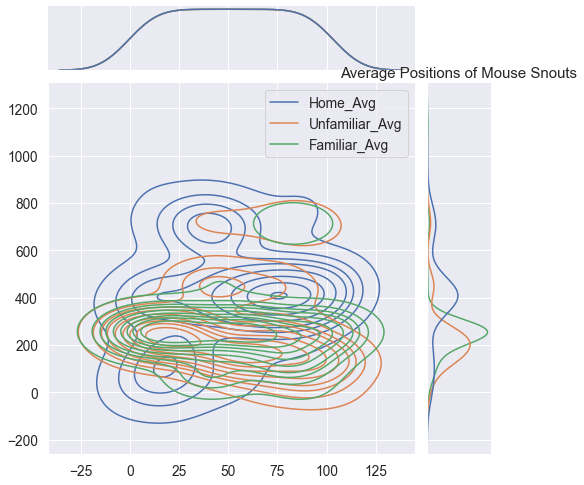

In [16]:
ax = sns.set(font_scale=1.25)
g = sns.jointplot(
    data=snout_avg_simpleimp_df,
    #x="bill_length_mm", y="bill_depth_mm", hue="species",
    kind="kde", height = 7
)

plt.title('Average Positions of Mouse Snouts')

In [17]:
marker_distance_df.head()


,H&U_S_mean,H&U_LE_mean,H&U_RE_mean,H&U_TB_mean,H&F_S_mean,H&F_LE_mean,H&F_RE_mean,H&F_TB_mean,U&F_S_mean,U&F_LE_mean,U&F_RE_mean,U&F_TB_mean
0,508.895161,193.232384,113.405071,514.2438,658.701022,267.702609,116.696043,413.425348,149.80586,154.846239,137.178699,100.818452
1,508.260661,476.806717,116.220571,507.6933,658.066522,321.960478,119.511543,406.874848,149.80586,154.846239,137.178699,100.818452
2,511.689661,194.992384,119.672571,504.5648,661.495522,269.462609,122.963543,403.746348,149.80586,154.846239,137.178699,100.818452
3,88.910806,362.847783,125.745071,498.5648,87.484304,517.694022,129.036043,397.746348,149.80586,154.846239,137.178699,100.818452
4,112.609306,201.151884,135.815571,498.5323,111.182804,275.622109,139.106543,397.713848,149.80586,154.846239,137.178699,100.818452


In [18]:
average_distance_df.head()

,Average_H&U,Average_H&F,Average_U&F
0,332.444104,364.131255,135.662313
1,402.245313,376.603348,135.662313
2,332.729854,364.417005,135.662313
3,269.017115,282.990179,135.662313
4,237.027265,230.906326,135.662313


In [19]:
#Reshaping data for plotting purposes
#for all markers
melt_distance_df=average_distance_df.copy()
melt_distance_df=melt_distance_df.melt(var_name='Relationship', value_name='Average Distance'
                                      )
#For total average distance
melt_marker_df=marker_distance_df.copy()
melt_marker_df=melt_marker_df.melt(var_name='Relationship', value_name='Average Distance'
                                      )

melt_distance_df.head()
#melt_marker_df.head()



,Relationship,Average Distance
0,Average_H&U,332.444104
1,Average_H&U,402.245313
2,Average_H&U,332.729854
3,Average_H&U,269.017115
4,Average_H&U,237.027265


In [20]:
melt_distance_df['Frame']=melt_distance_df.index
melt_distance_df.head()

,Relationship,Average Distance,Frame
0,Average_H&U,332.444104,0
1,Average_H&U,402.245313,1
2,Average_H&U,332.729854,2
3,Average_H&U,269.017115,3
4,Average_H&U,237.027265,4


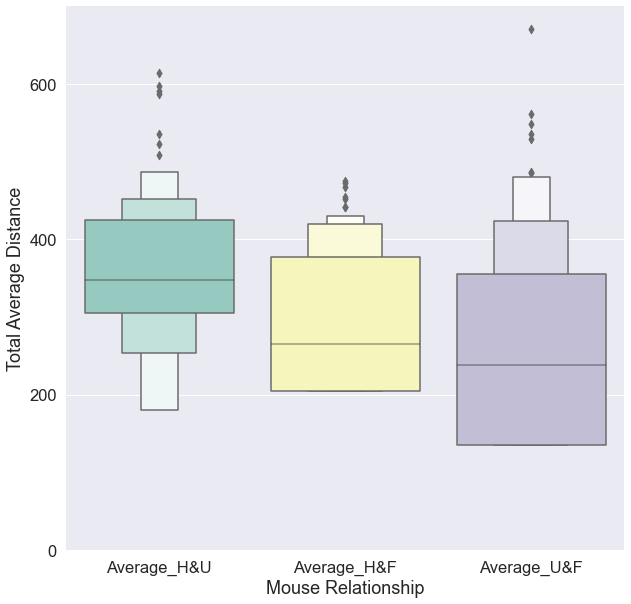

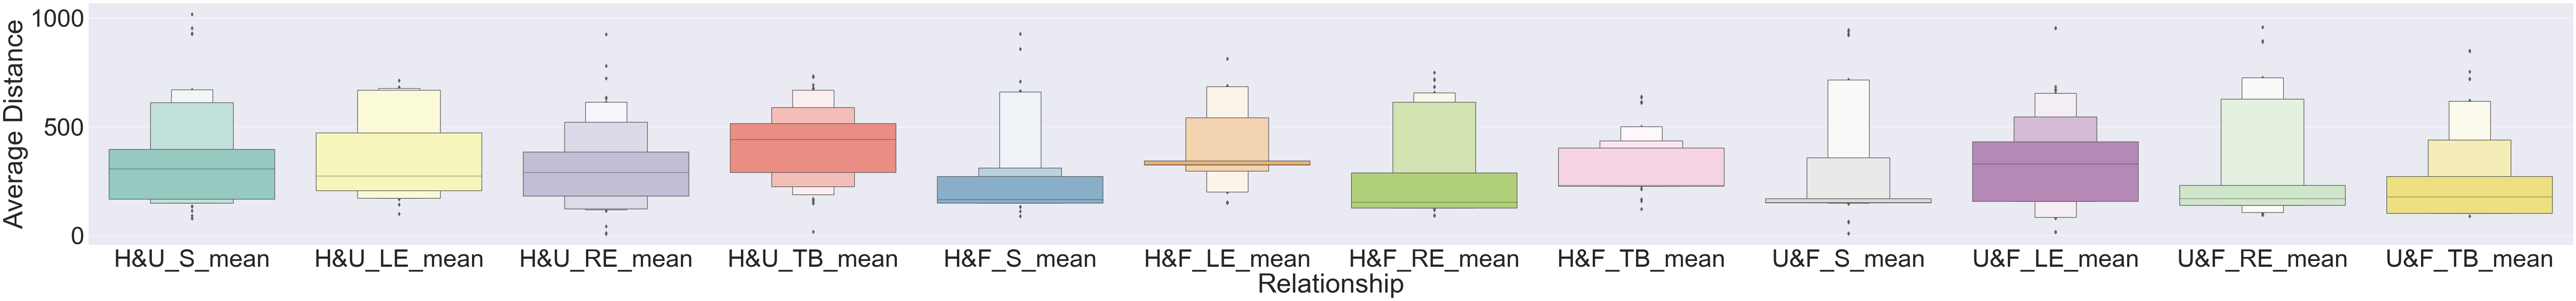

In [21]:
#Show the distributions of total average distancee between the different mice
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
ax = sns.boxenplot(x=melt_distance_df['Relationship'], palette="Set3", y='Average Distance',
                 data=melt_distance_df, #order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

ax.set(ylim=(0, 700), xlabel= "Mouse Relationship", ylabel="Total Average Distance"
      )
sns.despine(left=True, bottom=True)

#Show the distributions of average distancee between markers of the different mice
plt.figure(figsize=(100,10))
ax = sns.set(font_scale=5)
ax = sns.boxenplot(x=melt_marker_df['Relationship'], palette="Set3", y='Average Distance',
                 data=melt_marker_df, #order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

#ax.set(ylim=(0, 700), xlabel= "Mouse Relationship", ylabel="Total Average Distance"
     # )
sns.despine(left=True, bottom=True)


### Try to make facet grids in refined steps
#g = sns.catplot(x=melt_marker_df['Relationship'], palette="Set3", y='Average Distance',
                #row='Relationship',
                #data=melt_marker_df, kind="boxen",
                #height=4, aspect=.7
               #);

## From the dist. plots
   I wonder if the Unfamiliar Mouse and the Familiar Mouse appear to be closer on average because of the imputed times that they are together (i.e. close when they aren't even in the cage together). To solve this, either plot times where all three are present (also mitigates imputation issue) or plot each mouse only at the times when they are present in the cage (pass tuples to the plot?).melt_distance_df

In [22]:
average_distance_df.tail()


,Average_H&U,Average_H&F,Average_U&F
102,298.597647,205.301245,210.403277
103,295.801397,205.301245,207.489310
104,258.465445,205.301245,207.961449
105,257.656070,205.301245,207.152074
106,246.958195,205.301245,196.454199


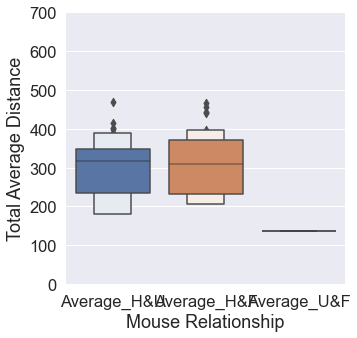

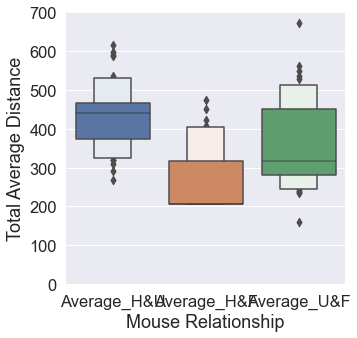

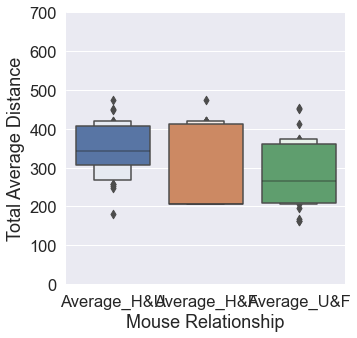

In [27]:
# Dist. for only Home mouse in cage
plt.figure(figsize=(5,5))
ax = sns.set(font_scale=1.5)
ax = sns.boxenplot(#x=average_distance_df['Relationship'], palette="Set3", y='Average Distance',
                 data=average_distance_df.loc[:35], #order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

ax.set(ylim=(0, 700), xlabel= "Mouse Relationship", ylabel="Total Average Distance"
      )
sns.despine(left=True, bottom=True)



#Dist. for when home and unfamiliar mouse are in cage
plt.figure(figsize=(5,5))
ax = sns.set(font_scale=1.5)
ax = sns.boxenplot(#x=melt_distance_df['Relationship'], palette="Set3", y='Average Distance',
                 data=average_distance_df.loc[36:71], #order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

ax.set(ylim=(0, 700), xlabel= "Mouse Relationship", ylabel="Total Average Distance"
      )
sns.despine(left=True, bottom=True)


#Dist for when all three mice are in the cage
plt.figure(figsize=(5,5))
ax = sns.set(font_scale=1.5)
ax = sns.boxenplot(#x=melt_distance_df['Relationship'], palette="Set3", y='Average Distance',
                 data=average_distance_df.loc[72:107], #order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

ax.set(ylim=(0, 700), xlabel= "Mouse Relationship", ylabel="Total Average Distance"
      )
sns.despine(left=True, bottom=True)


## Parsing Matters
    The above plots show that, to be expected, the home and familiar mouse are closer on aveerage than with the unfamiliar mouse when all three are present. The plots were made based on when each mouse was introduced to the cage, and show different resuluts than when plotted as a whole. Thus, we shoudl use only frames from all three mice to make many conclusions. or, do it like the above avample and show the different epochs.

In [24]:
melt_distance_df.loc[105:110]

,Relationship,Average Distance,Frame
105,Average_H&U,257.656070,105
106,Average_H&U,246.958195,106
107,Average_H&F,364.131255,107
108,Average_H&F,376.603348,108
109,Average_H&F,364.417005,109
110,Average_H&F,282.990179,110


KeyError: None

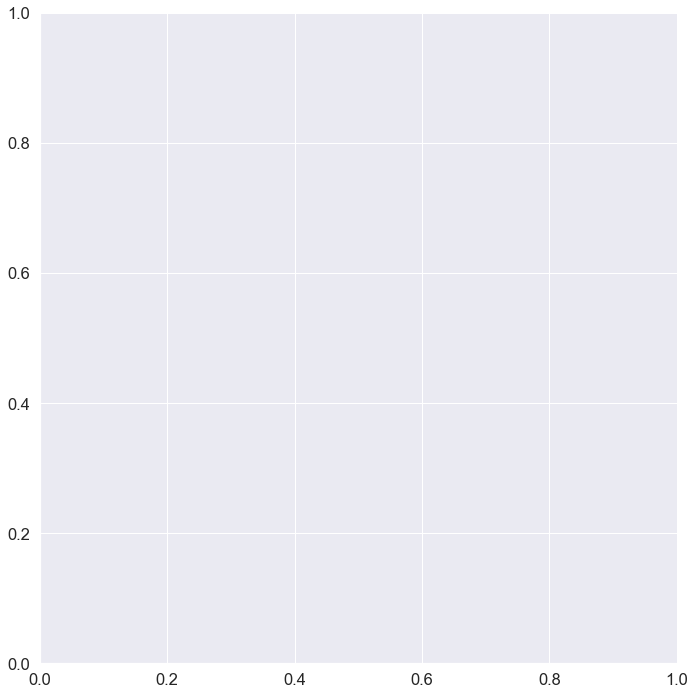

In [25]:
#Almost there, the x-axis really isn't frames, but the closer to 0 the line, the moree coorelated the distance between the mice 
sns.lmplot(#x='Frame', y='Average Distance', hue="Relationship",
           data=average_distance_df.loc[:35],
    height=10
)

sns.lmplot(#x='Frame', y='Average Distance', hue="Relationship",
           data=average_distance_df.loc[36:71],
    height=10
)

sns.lmplot(#x='Frame', y='Average Distance', hue="Relationship",
           data=average_distance_df.loc[72:107],
    height=10
)

Text(0.5, 1.0, 'Average Positions of Mouse Distances')

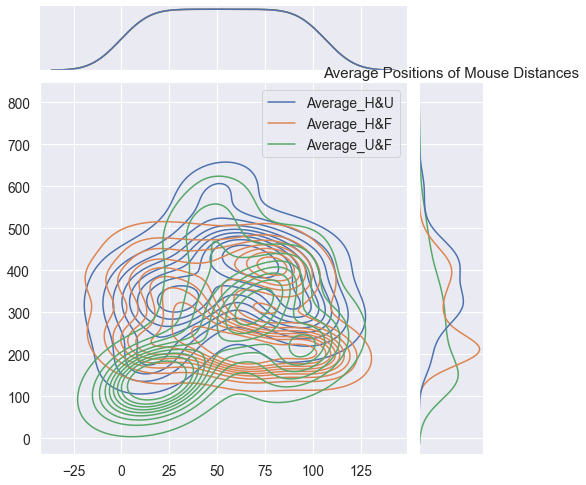

In [28]:
#Show the distributions of the mive average distances as a function of time
ax = sns.set(font_scale=1.25)
g = sns.jointplot(
    data=average_distance_df,
    #x="bill_length_mm", y="bill_depth_mm", hue="species",
    kind="kde", height = 7
)

plt.title('Average Positions of Mouse Distances')

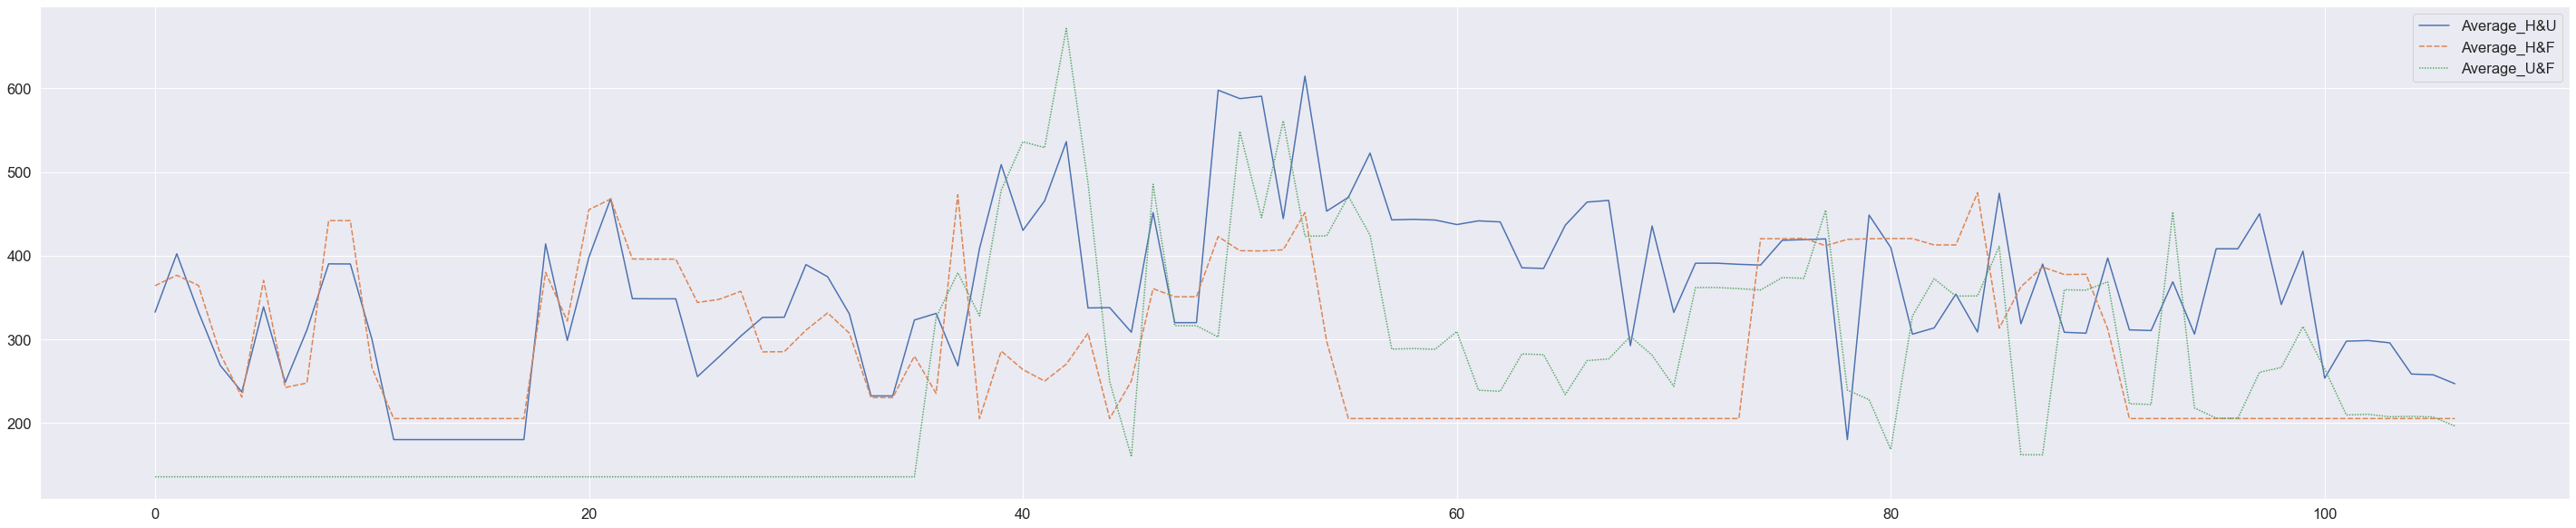

In [29]:
plt.figure(figsize=(50,10))
ax = sns.set(font_scale=1.5)
ax = sns.lineplot(#x=melt_distance_df['Relationship'], palette="Set3", y='Average Distance',
                 data=average_distance_df, #hue="Relationship"#order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H']
)

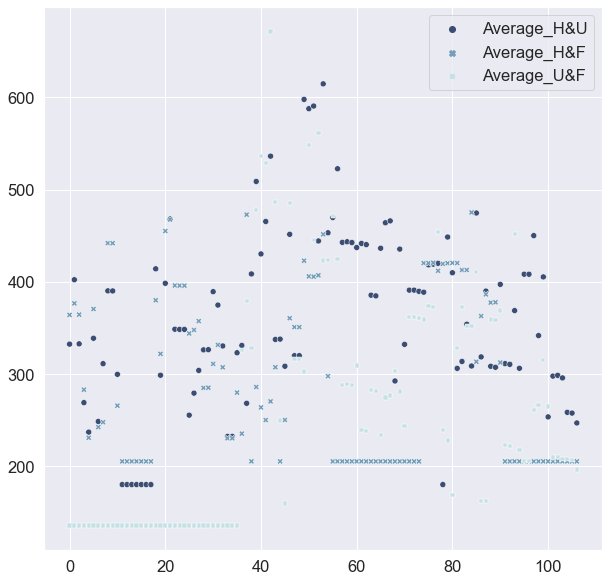

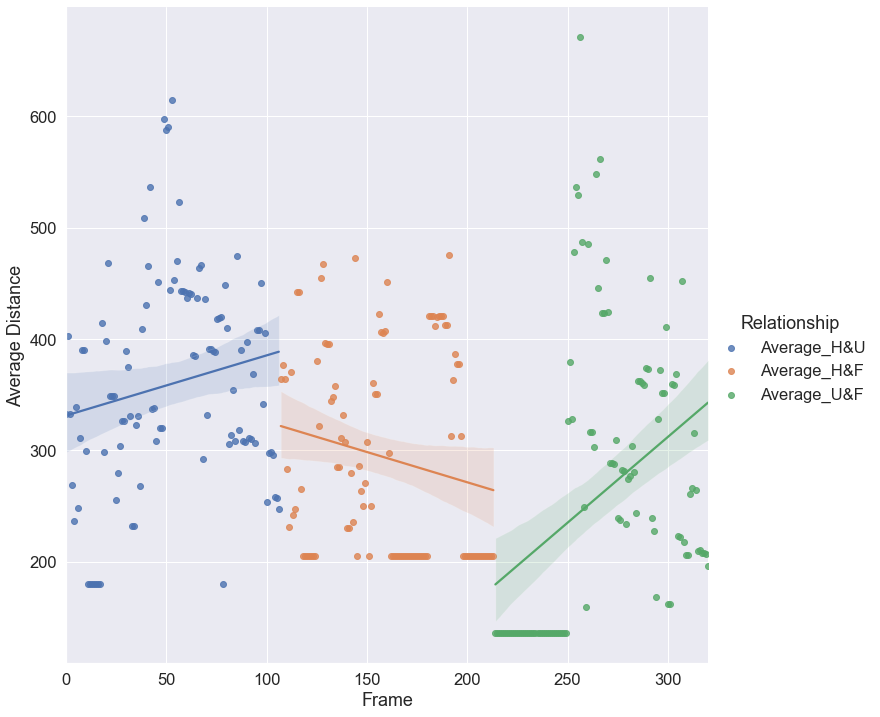

In [30]:
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
sns.scatterplot(#x="carat", y="price",
                #hue="clarity", size="depth",
                palette="ch:r=-.2,d=.3_r",
                #hue_order=clarity_ranking,
                #sizes=(1, 8), linewidth=0,
                data=average_distance_df, #ax=ax
)


#Almost there, the x-axis really isn't frames, but the closer to 0 the line, the moree coorelated the distance between the mice 
sns.lmplot(x='Frame', y='Average Distance',data=melt_distance_df, hue="Relationship",
    height=10
)